In [1]:
#%load_ext autoreload
#%autoreload 2


import sys
sys.path.append("../../mrf-sim/")
sys.path.append("../../epgpy/")
sys.path.append("../../machines/")
sys.path.append("../../mutools/")
sys.path.append("../../dicomstack/")

#import matplotlib
#matplotlib.use("TkAgg")
from mrfsim import T1MRF
from image_series import *
from utils_mrf import regression_paramMaps_ROI,buildROImask
import json
from finufft import nufft1d1,nufft1d2
from scipy import signal,interpolate
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import numpy as np
from movements import *
from dictoptimizers import *

%matplotlib inline


In [2]:


## Random map simulation

dictfile = "../mrf175_SimReco2.dict"
#dictfile = "mrf175_CS.dict"

with open("../mrf_sequence.json") as f:
    sequence_config = json.load(f)


seq = T1MRF(**sequence_config)

window = 8 #corresponds to nspoke by image
size=(256,256)

file_matlab_paramMap = "../data/SquarePhantom/Phantom1/paramMap.mat"
useGPU=True


In [3]:

###### Building Map
m = MapFromFile("TestPhantomV1",image_size=size,file=file_matlab_paramMap,rounding=False)

m.buildParamMap()

##### Simulating Ref Images
m.build_ref_images(seq,window)



Building Param Map
Building Ref Images
Simulating Water Signal


KeyboardInterrupt: 

In [ ]:
ntimesteps=175
nspoke=8
npoint = 2*m.images_series.shape[1]

radial_traj=Radial(ntimesteps=ntimesteps,nspoke=nspoke,npoint=npoint)
kdata = m.generate_radial_kdata(radial_traj,useGPU=useGPU)

volumes = simulate_radial_undersampled_images(kdata,radial_traj,m.image_size,density_adj=True,useGPU=useGPU)
mask = build_mask_single_image(kdata,radial_traj,m.image_size)

optimizer = SimpleDictSearch(mask=mask,niter=10,seq=seq,trajectory=radial_traj,split=500,pca=True,threshold_pca=15,log=False,useAdjPred=False,useGPU=useGPU)
all_maps_adj=optimizer.search_patterns(dictfile,volumes)


In [ ]:
file_rebuilt_matlab = "../data/SquarePhantom/Phantom1/MRFmap8SpokesSVD15_iter4_method1.mat"

map_rebuilt_Matlab=MapFromFile("MapRebuiltMatlab",image_size=size,file=file_rebuilt_matlab,rounding=False,file_type="Result")
map_rebuilt_Matlab.buildParamMap()


/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(9000,)
(9000,)


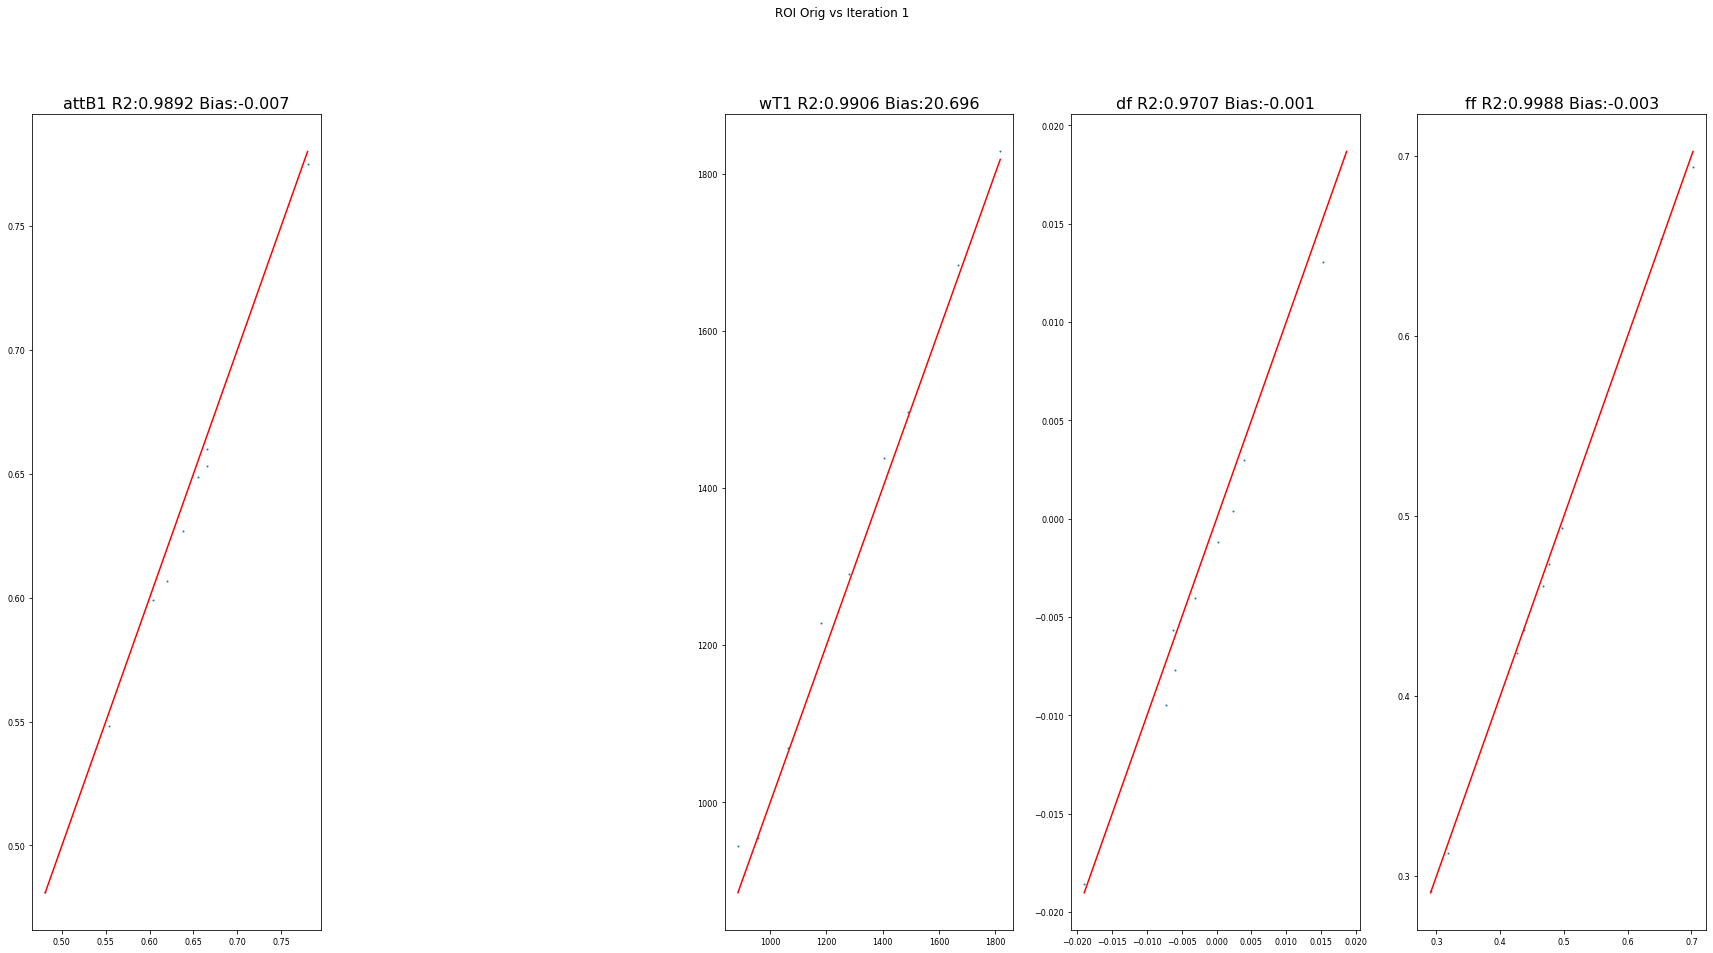

In [109]:
#import importlib

#importlib.reload(utils_mrf)

#
it = 1

regression_paramMaps_ROI(m.paramMap, all_maps_adj[it][0], m.mask > 0, all_maps_adj[it][1] > 0,
                             title="ROI Orig vs Iteration {}".format(it), proj_on_mask1=True, adj_wT1=True, fat_threshold=0.7,figsize=(30,15))

In [78]:
all_maps_adj.items()

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_items([(0, ({'wT1': array([1600., 1700., 1900., ..., 1900., 2000., 1700.]), 'fT1': array([300., 300., 300., ..., 300., 300., 300.]), 'attB1': array([0.6 , 0.75, 0.7 , ..., 1.  , 1.  , 1.  ]), 'df': array([-0.   , -0.   , -0.015, ...,  0.015,  0.015,  0.015]), 'ff': array([0.50251473, 0.43761486, 0.39399807, ..., 0.29216742, 0.29650531,
       0.27554803])}, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]))), (1, ({'wT1': array([1560., 1520., 1650., ..., 1750., 1850., 1600.]), 'fT1': array([300., 300., 300., ..., 300., 300., 300.]), 'attB1': array([0.3 , 0.3 , 0.3 , ..., 1.  , 1.  , 0.95]), 'df': array([-0.015, -0.015, -0.015, ...,  0.015,  0.015,  0.03 ]), 'ff': array([0.59521476, 0.58333811, 0.58000197, ..., 0.35025235, 0.34964788,
       0.35052819])}, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0,

In [106]:
def plot_evolution_params(map_ref,mask_ref,all_maps,adj_wT1=True,title="R2 Evolution",fat_threshold=0.7,proj_on_mask1=True,fontsize=5,figsize=(15,40)):
    
    keys_1 = set(map_ref.keys())
    keys_2 = set(all_maps[0][0].keys())
    nb_keys=len(keys_1 & keys_2)
    fig,ax = plt.subplots(nb_keys,figsize=figsize)
    maskROI = buildROImask(map_ref)

    for i,k in enumerate(keys_1 & keys_2):
        print(i)
        r_2_list = []
        for it,value in all_maps.items():
            
            map2 = value[0]
            mask2 = value[1]>0

            mask_union = mask_ref | mask2
            mat_obs = makevol(map_ref[k],mask_ref)
            mat_pred = makevol(map2[k],mask2)
            mat_ROI = makevol(maskROI, mask_ref)
            if proj_on_mask1:
                mat_pred = mat_pred*(mask_ref*1)

            obs = mat_obs[mask_union]
            pred = mat_pred[mask_union]
            maskROI_current=mat_ROI[mask_union]

            if adj_wT1 and k=="wT1":
                ff = map2["ff"]
                obs = obs[ff < fat_threshold]
                pred = pred[ff < fat_threshold]
                maskROI_current=maskROI_current[ff < fat_threshold]

            df_obs = pd.DataFrame(columns=["Data", "Groups"], data=np.stack([obs.flatten(), maskROI_current.flatten()],axis=-1))
            df_pred = pd.DataFrame(columns=["Data", "Groups"], data=np.stack([pred.flatten(), maskROI_current.flatten()],axis=-1))
            obs = np.array(df_obs.groupby("Groups").mean())[1:]
            pred = np.array(df_pred.groupby("Groups").mean())[1:]

            x_min = np.min(obs)
            x_max = np.max(obs)
            
            if x_min==x_max:
                fig.delaxes(ax[i])
                break

            mean=np.mean(obs)
            ss_tot = np.sum((obs-mean)**2)
            ss_res = np.sum((obs-pred)**2)
            bias = np.mean((pred-obs))
            r_2 = 1-ss_res/ss_tot
            r_2_list.append(r_2)
        
        n_it = len(r_2_list)
        ax[i].plot(range(n_it), r_2_list, "r")
        ax[i].set_title(k+" Evolution over Iteration",fontsize=2*fontsize)
        ax[i].tick_params(axis='x', labelsize=fontsize)
        ax[i].tick_params(axis='y', labelsize=fontsize)

    plt.suptitle(title)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(9000,)
(9000,)
0
1
2
3
4


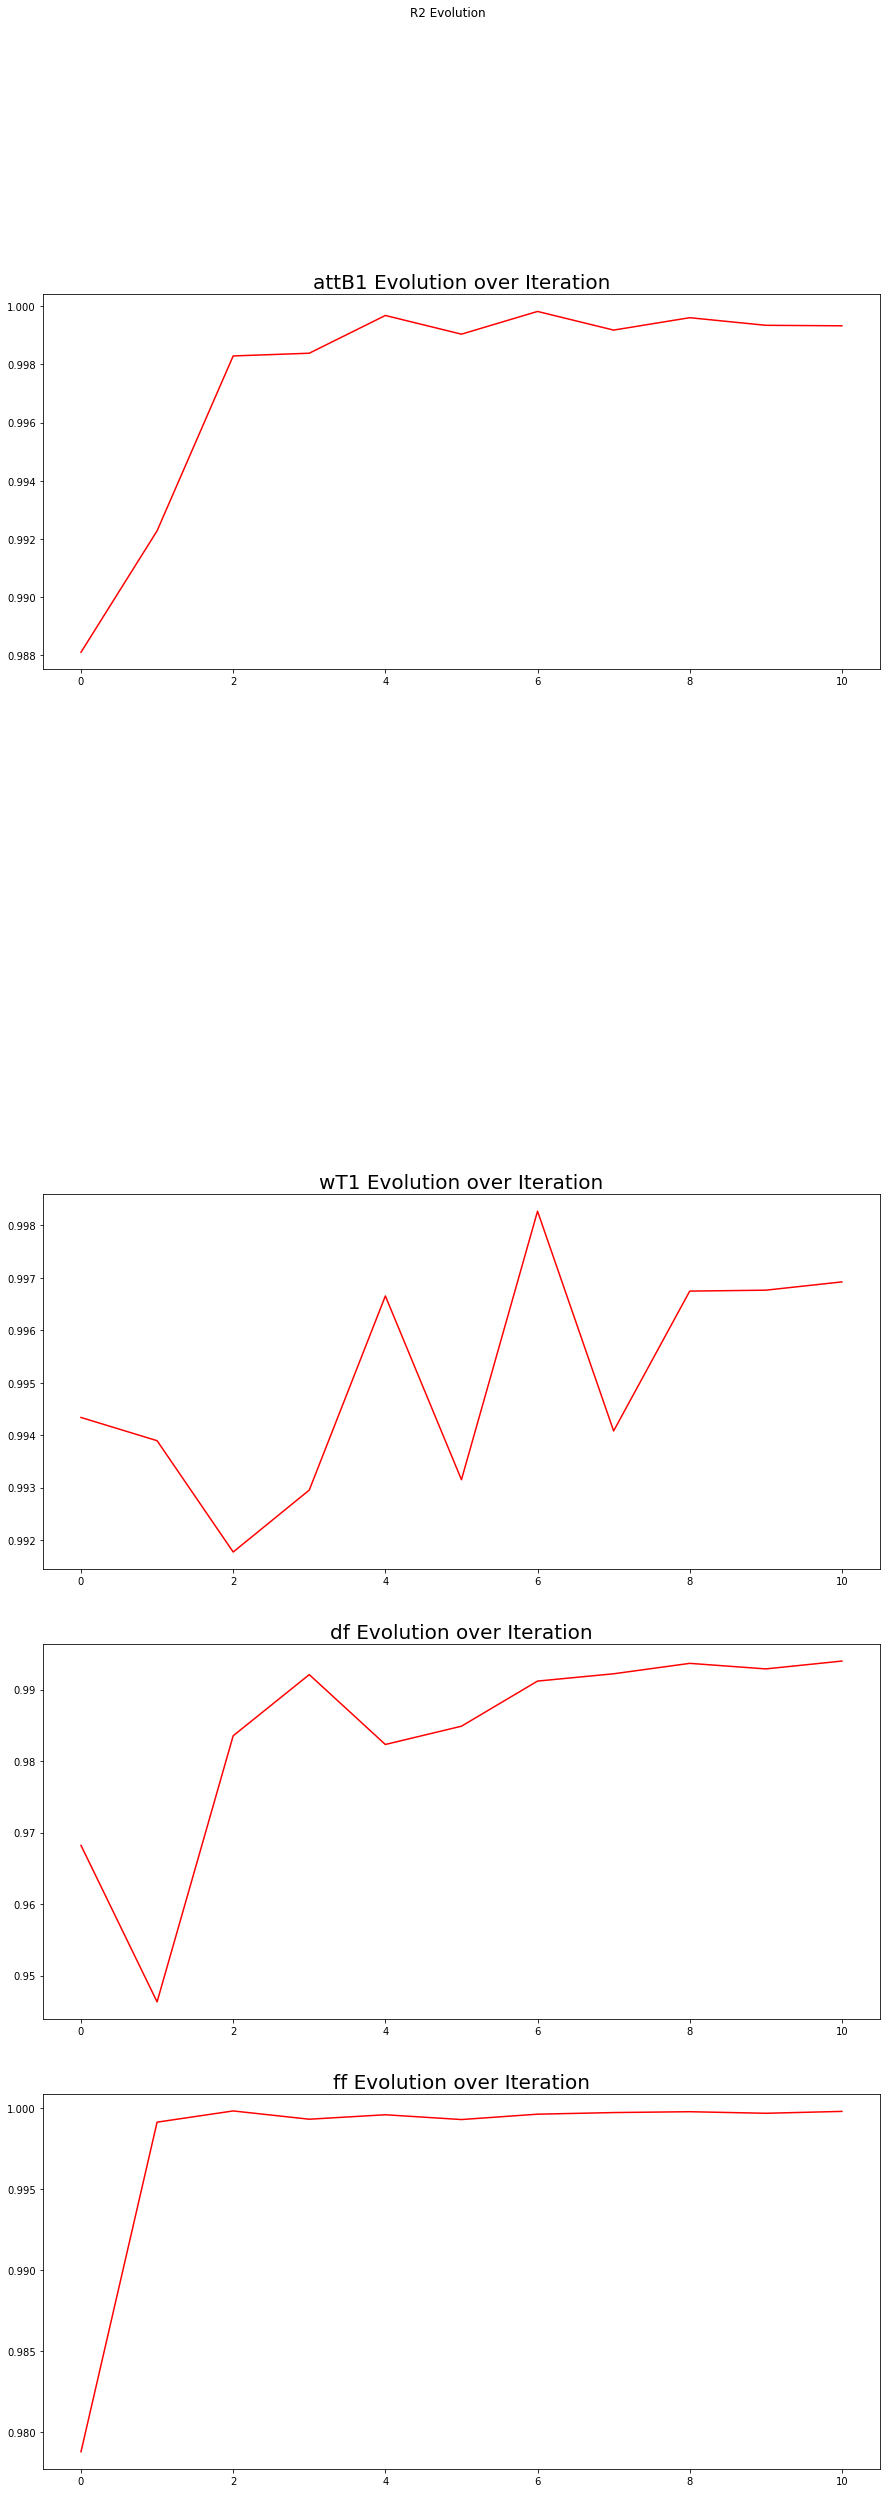

In [108]:
plot_evolution_params(m.paramMap,m.mask>0,all_maps_adj,fontsize=10)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(9000,)
(9000,)


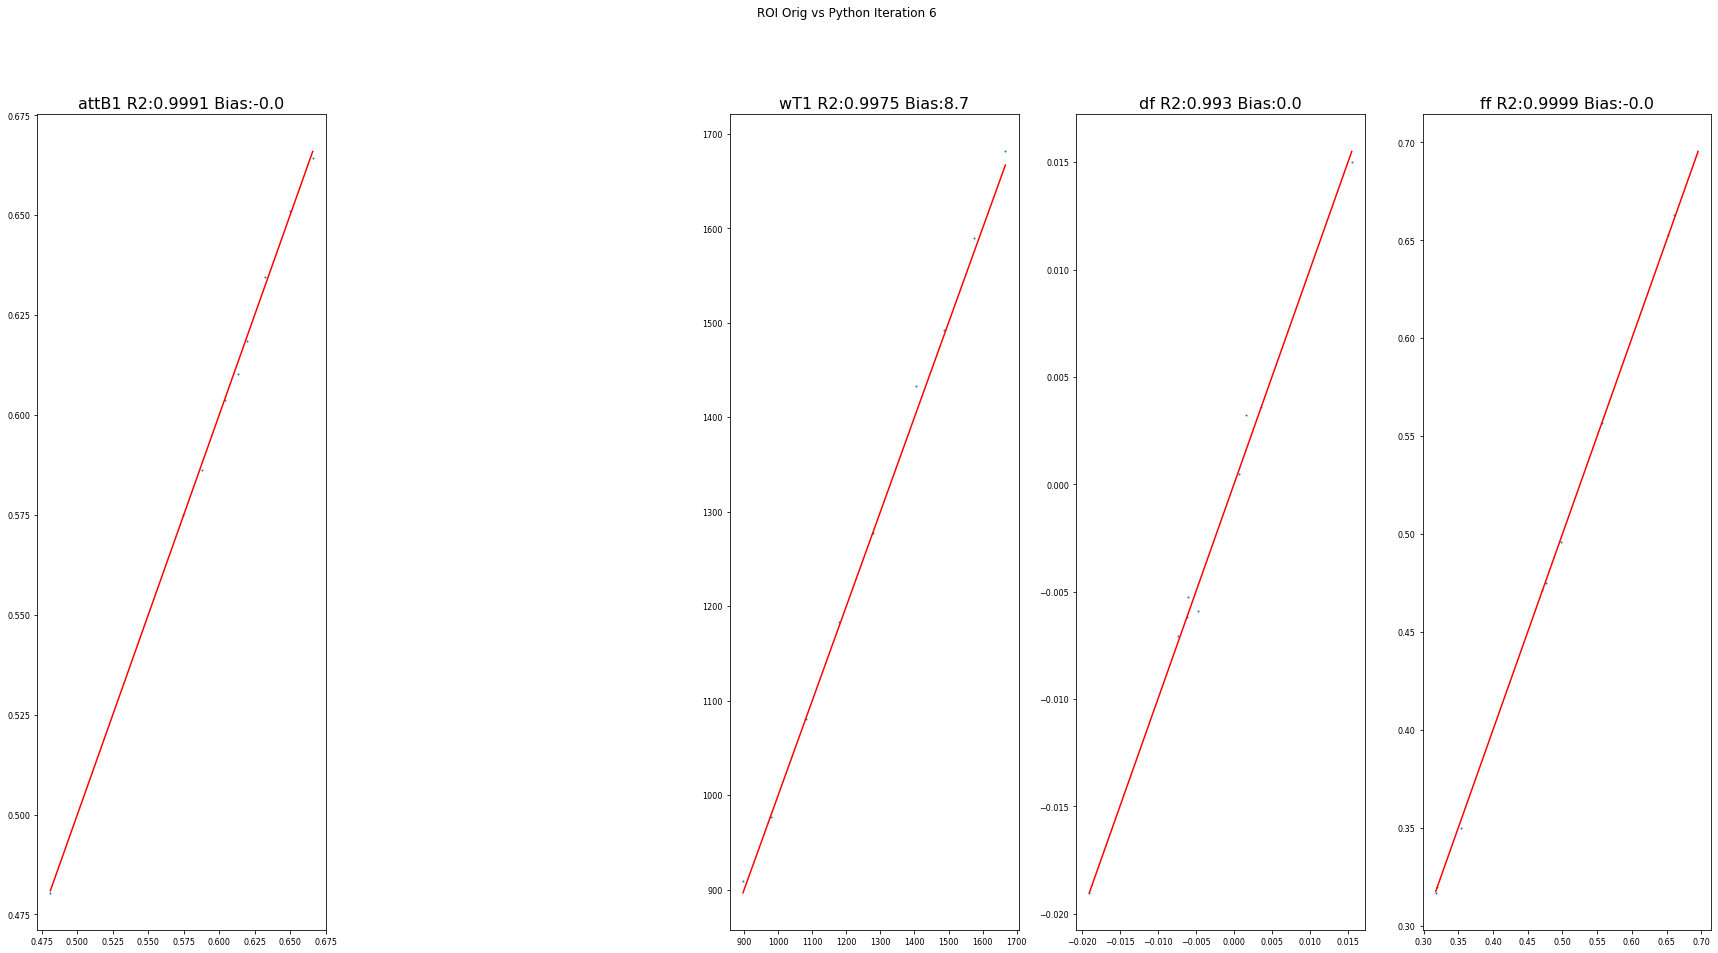

In [112]:
#import importlib

#importlib.reload(utils_mrf)

#
it = 6

regression_paramMaps_ROI(m.paramMap, all_maps_adj[it][0], m.mask > 0, all_maps_adj[it][1] > 0,
                             title="ROI Orig vs Python Iteration {}".format(it), proj_on_mask1=True, adj_wT1=True, fat_threshold=0.7,figsize=(30,15),fontsize=8)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(9000,)
(9000,)


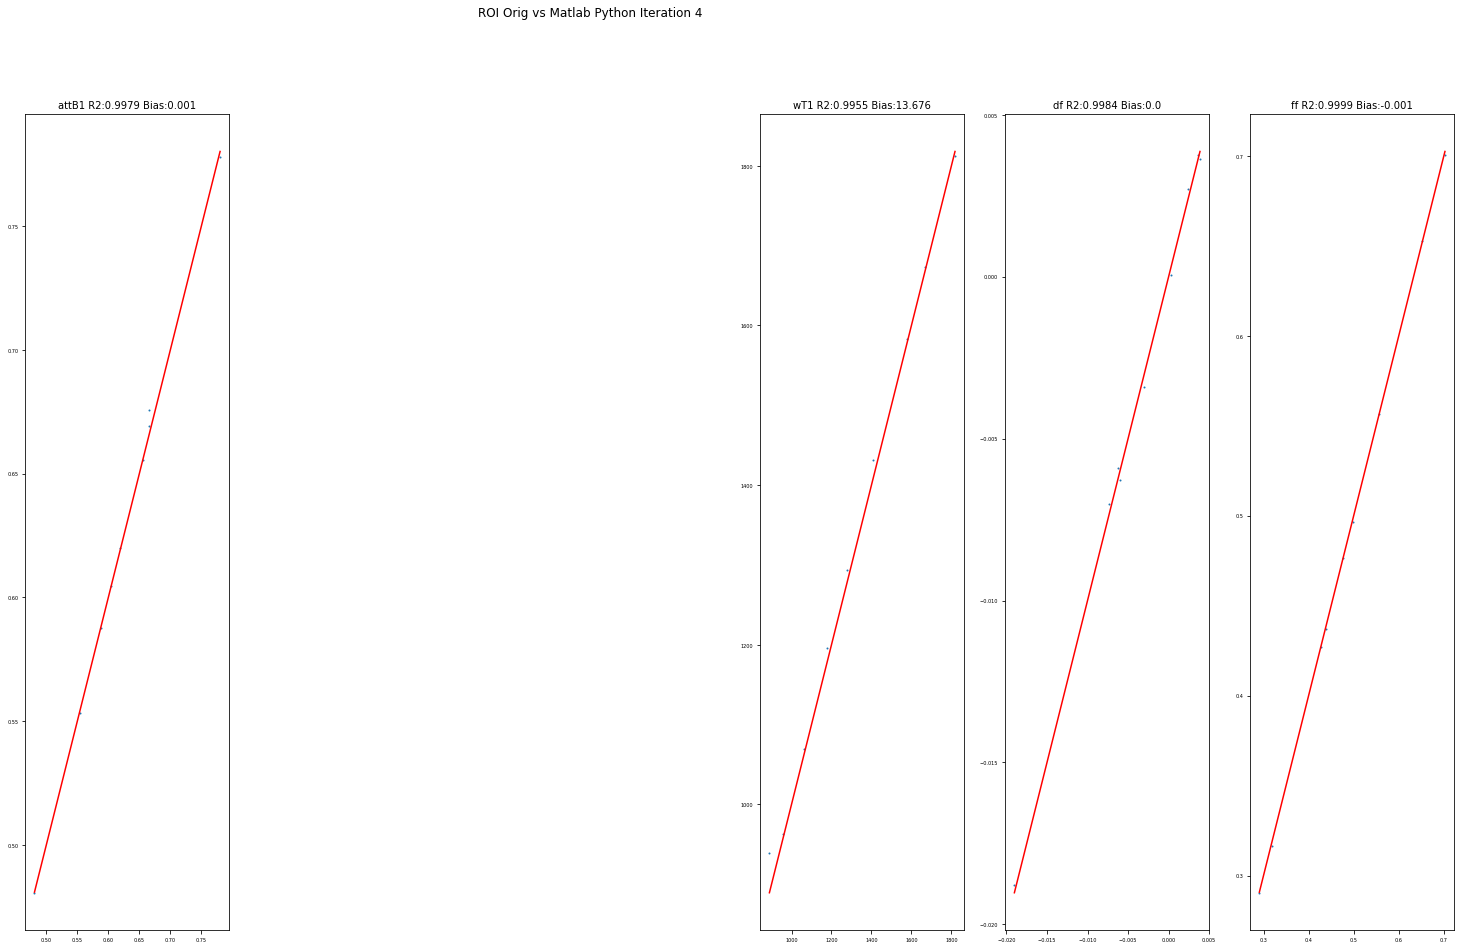

In [64]:

regression_paramMaps_ROI(m.paramMap, map_rebuilt_Matlab.paramMap, m.mask > 0, map_rebuilt_Matlab.mask > 0,
                             title="ROI Orig vs Matlab Iteration 4", proj_on_mask1=True, adj_wT1=True, fat_threshold=0.7,figsize=(30,15))

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


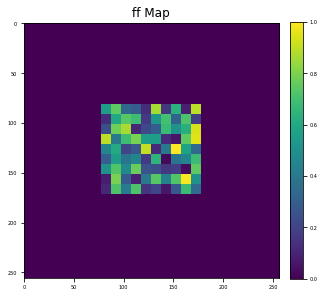

In [150]:
m.plotParamMap("ff")

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


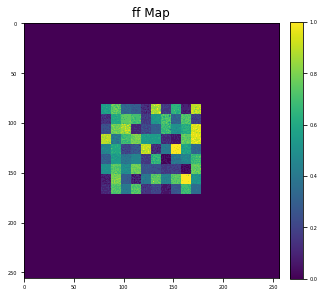

In [151]:
map_rebuilt_Matlab.plotParamMap("ff")

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


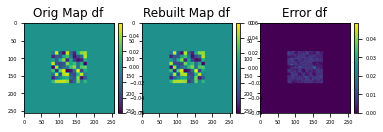

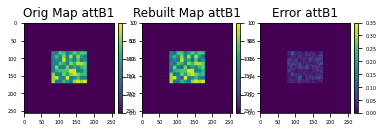

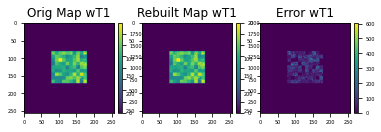

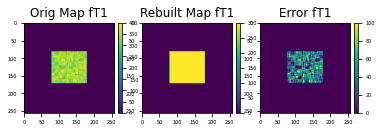

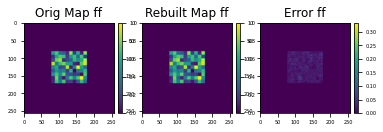

In [158]:
compare_paramMaps(all_maps_adj[2][0],map_rebuilt_Matlab.paramMap,all_maps_adj[2][1]>0,map_rebuilt_Matlab.mask>0,adj_wT1=True,fat_threshold=0.7)

In [156]:
np.unique(m.paramMap["fT1"])

array([350.])

In [155]:
np.unique(map_rebuilt_Matlab.paramMap["fT1"])

array([300.])

In [ ]:
map_rebuilt_Matlab.plotParamMap("ff")

# Compare Param Map

In [165]:
makevol(m.paramMap["wT1"],m.mask>0)[82,77]==1586

True

In [167]:
makevol(m.paramMap["ff"],m.mask>0)[82,77]==0.5619

False

In [186]:
makevol(m.paramMap["df"],m.mask>0)[82,77]==-11.6654/1000

False

In [187]:
makevol(m.paramMap["df"],m.mask>0)[82,77]

-0.012

In [189]:
makevol(m.paramMap["attB1"],m.mask>0)[82,77]==0.4289

False

In [190]:
makevol(m.paramMap["attB1"],m.mask>0)[82,77]

0.43

In [185]:
makevol(map_rebuilt_Matlab.paramMap["df"],map_rebuilt_Matlab.mask>0)[82,77]

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-0.015

# Compare sequence

In [169]:
param_seq={"TI": 8.32, "FA": 5, "TE": [2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63], "TR": [3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76], "B1": [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}

In [175]:
param_seq.keys()

dict_keys(['TI', 'FA', 'TE', 'TR', 'B1'])

In [174]:
np.unique(np.array(param_seq["TR"])-np.array(param_seq["TE"]))

array([1.13])

In [172]:
np.max(np.abs(np.array(param_seq["TE"])-matlab_TE))

0.0

In [177]:
np.max(np.abs(np.array(param_seq["B1"])-matlab_B1))

0.0

# Param Dico

In [9]:
paramDico_matlab = loadmat("./Data_Matlab/paramDico_empty.mat")

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
paramDico_matlab["paramDico"]

array([[(array([[2]], dtype=uint8), array([[array([[40]], dtype=uint8), array([[80]], dtype=uint8)]],
              dtype=object), array([[0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
                0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]]), array([[0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 ,
                0.85, 0.9 , 0.95, 1.  ]]), array([[-60, -45, -30, -15,   0,  15,  30,  45,  60]], dtype=int16), array([[array([[180]], dtype=uint8), array([[180]], dtype=uint8)]],
              dtype=object), array([[array([[ 550,  560,  570,  580,  590,  600,  610,  620,  630,  640,  650,
                         660,  670,  680,  690,  700,  710,  720,  730,  740,  750,  760,
                         770,  780,  790,  800,  810,  820,  830,  840,  850,  860,  870,
                         880,  890,  900,  910,  920,  930,  940,  950,  960,  970,  980,
                         990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 108

In [46]:
list(paramDico_matlab["paramDico"]["FA"][0,0][0])

[0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6000000000000001,
 0.6499999999999999,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95,
 1.0]

In [47]:
list(paramDico_matlab["paramDico"]["Df"][0,0][0])

[-60, -45, -30, -15, 0, 15, 30, 45, 60]

In [48]:
list(paramDico_matlab["paramDico"]["T2"][0,0][0])

[array([[40]], dtype=uint8), array([[80]], dtype=uint8)]

In [44]:
list(paramDico_matlab["paramDico"]["FF"][0,0][0])

[0.0,
 0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.30000000000000004,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.6499999999999999,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95,
 1.0]

In [36]:
list(paramDico_matlab["paramDico"]["T1"][0,0][0,0][0])

[550,
 560,
 570,
 580,
 590,
 600,
 610,
 620,
 630,
 640,
 650,
 660,
 670,
 680,
 690,
 700,
 710,
 720,
 730,
 740,
 750,
 760,
 770,
 780,
 790,
 800,
 810,
 820,
 830,
 840,
 850,
 860,
 870,
 880,
 890,
 900,
 910,
 920,
 930,
 940,
 950,
 960,
 970,
 980,
 990,
 1000,
 1010,
 1020,
 1030,
 1040,
 1050,
 1060,
 1070,
 1080,
 1090,
 1100,
 1110,
 1120,
 1130,
 1140,
 1150,
 1160,
 1170,
 1180,
 1190,
 1200,
 1210,
 1220,
 1230,
 1240,
 1250,
 1260,
 1270,
 1280,
 1290,
 1300,
 1310,
 1320,
 1330,
 1340,
 1350,
 1360,
 1370,
 1380,
 1390,
 1400,
 1410,
 1420,
 1430,
 1440,
 1450,
 1460,
 1470,
 1480,
 1490,
 1500,
 1510,
 1520,
 1530,
 1540,
 1550,
 1560,
 1570,
 1580,
 1590,
 1600,
 1650,
 1700,
 1750,
 1800,
 1850,
 1900,
 1950,
 2000]

In [37]:
list(paramDico_matlab["paramDico"]["T1"][0,0][0,1][0])

[300]

# Compare Simulation Ideal

In [6]:
sim_matlab = loadmat("./Data_Matlab/ImgSeries_ideal_iter_TestCS0.mat")

In [7]:
sim_matlab['ImgSeries'].shape

(256, 256, 1, 1400)

In [8]:
simulations = np.squeeze(sim_matlab['ImgSeries'])
simulations=np.moveaxis(simulations,-1,0)

In [37]:
simulations_reshaped = simulations.reshape((simulations.shape[0],-1))
window=8
means = [np.mean(gp, axis=0) for gp in groupby(simulations_reshaped, window)]
means=np.array(means)
matlab_means = means.reshape((means.shape[0],simulations.shape[1],-1))

In [41]:
python_means = np.array([np.mean(gp, axis=0) for gp in groupby(m.images_series, window)])

In [73]:
pixel=(125,125)

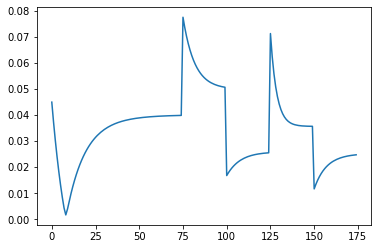

In [74]:
plt.plot(np.abs(m.images_series[:,pixel[0],pixel[1]]))

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


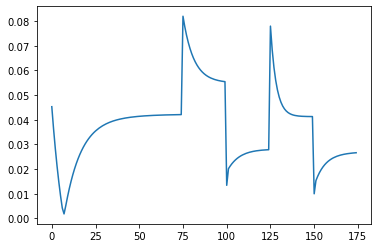

In [75]:
plt.plot(np.abs(simulations_mean[:,pixel[0],pixel[1]]))

In [40]:
python_means

[array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+

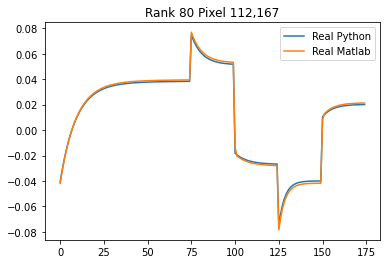

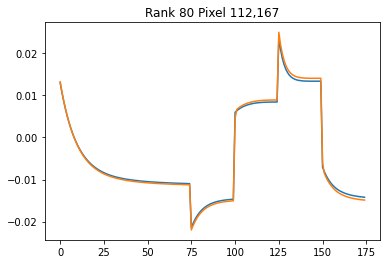

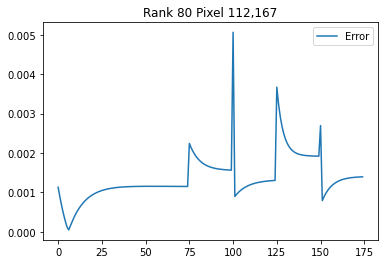

In [49]:
error = np.abs(python_means-matlab_means)
idx_max = np.argmax((error.flatten()))
idx_max=np.unravel_index(idx_max,error.shape)
plt.figure()
plt.plot(np.real(python_means[:,idx_max[1],idx_max[2]]),label="Real Python")
plt.plot(np.real(matlab_means[:,idx_max[1],idx_max[2]]),label="Real Matlab")
plt.title("Rank {} Pixel {},{}".format(rank,idx_max[1],idx_max[2]))
plt.legend()

plt.figure()
plt.plot(np.imag(python_means[:,idx_max[1],idx_max[2]]),label="Imag Python")
plt.plot(np.imag(matlab_means[:,idx_max[1],idx_max[2]]),label="Imag Matlab")
plt.title("Rank {} Pixel {},{}".format(rank,idx_max[1],idx_max[2]))

plt.figure()
plt.plot(np.real(error[:,idx_max[1],idx_max[2]]),label="Error")
plt.title("Rank {} Pixel {},{}".format(rank,idx_max[1],idx_max[2]))



plt.legend()

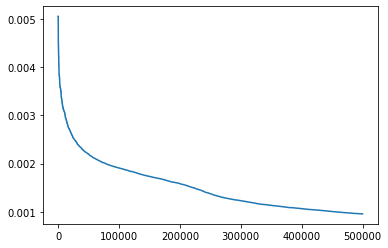

In [48]:
plt.plot(np.sort(error.flatten())[::-1][:500000])

In [44]:
np.argsort(error.flatten())[::-1]

array([6583211, 6582440, 6582442, ..., 7360864, 7360863,       0])

NameError: name 'simulations_mean' is not defined

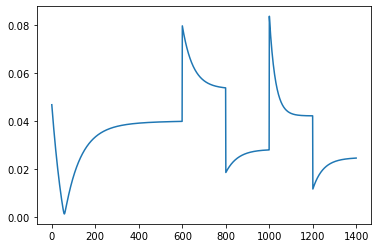

In [152]:


plt.plot(np.abs(m.images_series[:,idx_max[1],idx_max[2]]),label="Python")
plt.plot(np.abs(simulations_mean[:,idx_max[1],idx_max[2]]),label="Matlab")
plt.legend()

In [95]:
idx_max

(125, 132, 127)

In [51]:
window=8
np.ma.average(simulations,weights=np.ones(window),axis=0)

ValueError: Length of weights not compatible with specified axis.

In [94]:
m.build_ref_images(seq,1)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Building Ref Images
Simulating Water Signal
Simulating Fat Signal
Build dictionary.


In [53]:
simulations.shape

(1400, 256, 256)

In [54]:
1400/8

175.0

In [97]:
m.images_series.shape

(1400, 256, 256)

In [98]:
simulations.shape

(1400, 256, 256)

In [ ]:
error_all = np.abs(m.images_series-simulations)

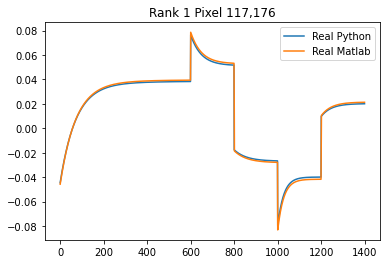

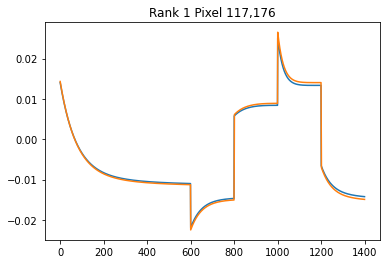

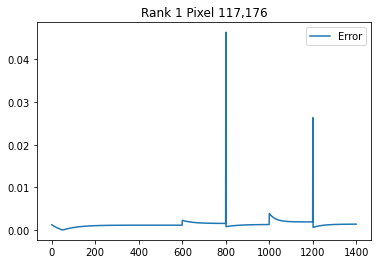

In [104]:

rank=1


idx_max = np.argsort((error_all.flatten()))[-rank]
#idx_max = np.argmax((error_all.flatten()))
idx_max=np.unravel_index(idx_max,error_all.shape)
plt.figure()
plt.plot(np.real(m.images_series[:,idx_max[1],idx_max[2]]),label="Real Python")
plt.plot(np.real(simulations[:,idx_max[1],idx_max[2]]),label="Real Matlab")
plt.title("Rank {} Pixel {},{}".format(rank,idx_max[1],idx_max[2]))
plt.legend()

plt.figure()
plt.plot(np.imag(m.images_series[:,idx_max[1],idx_max[2]]),label="Imag Python")
plt.plot(np.imag(simulations[:,idx_max[1],idx_max[2]]),label="Imag Matlab")
plt.title("Rank {} Pixel {},{}".format(rank,idx_max[1],idx_max[2]))

plt.figure()
plt.plot(np.real(error_all[:,idx_max[1],idx_max[2]]),label="Error")
plt.title("Rank {} Pixel {},{}".format(rank,idx_max[1],idx_max[2]))



plt.legend()

In [144]:
idx_max[0]

800

In [148]:
m.images_series[idx_max[0],idx_max[1],idx_max[2]]

(-0.017700108566527175+0.0057833566807044354j)

In [149]:
m.images_series[idx_max[0]+1,idx_max[1],idx_max[2]]

(-0.017863920032155495+0.005837492844086938j)

In [150]:
simulations[idx_max[0],idx_max[1],idx_max[2]]

(0.026679995408650112-0.007544962842699548j)

In [151]:
simulations[idx_max[0]+1,idx_max[1],idx_max[2]]

(-0.01861950907473215+0.006134678873789068j)

ff value in ground truth map is 0.7458474843427212


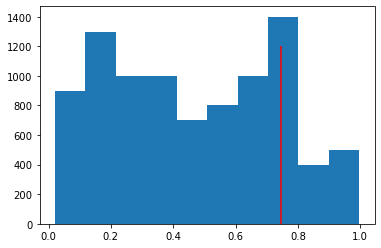

In [97]:
field = "ff"

print("{} value in ground truth map is {}".format(field,makevol(m.paramMap[field],m.mask>0)[idx_max[1],idx_max[2]]))
plt.hist(m.paramMap[field])
plt.vlines(x=makevol(m.paramMap[field],m.mask>0)[idx_max[1],idx_max[2]],ymin=0,ymax=1200,color="red")

In [ ]:
np.argmax()

wT1 value in ground truth map is 1650.5586562788112


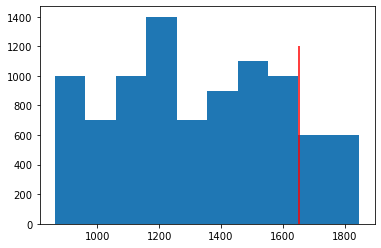

In [98]:
field = "wT1"

print("{} value in ground truth map is {}".format(field,makevol(m.paramMap[field],m.mask>0)[idx_max[1],idx_max[2]]))
plt.hist(m.paramMap[field])
plt.vlines(x=makevol(m.paramMap[field],m.mask>0)[idx_max[1],idx_max[2]],ymin=0,ymax=1200,color="red")

In [120]:
indices_max_error=np.unravel_index(np.argsort((error_all.flatten()))[::-1][:100000],error_all.shape)

In [121]:
mask_max = np.zeros(error_all.shape[1:])

In [134]:
indices_max_error_unique=np.unique(np.array(indices_max_error)[1:].T,axis=0)

In [125]:
mask_max[indices_max_error_unique]=1

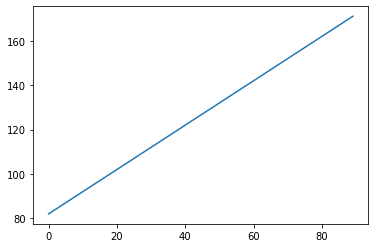

In [138]:
plt.plot(np.sort(np.unique(indices_max_error[1])))

In [140]:
len(np.unique(indices_max_error[1]))

90

In [141]:
len(np.unique(indices_max_error[2]))

100

In [143]:
(m.paramMap["wT1"]>0).sum()

9000

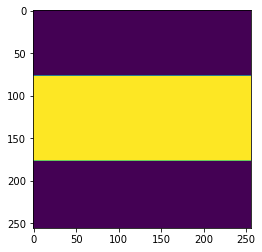

In [127]:
plt.imshow(mask_max)

In [126]:
mask_max.sum()

25600.0

attB1 value in ground truth map is 0.8691789695275325


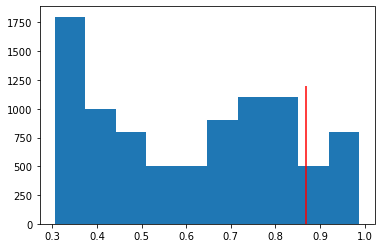

In [99]:
field = "attB1"

print("{} value in ground truth map is {}".format(field,makevol(m.paramMap[field],m.mask>0)[idx_max[1],idx_max[2]]))
plt.hist(m.paramMap[field])
plt.vlines(x=makevol(m.paramMap[field],m.mask>0)[idx_max[1],idx_max[2]],ymin=0,ymax=1200,color="red")

df value in ground truth map is 0.01400324176493649


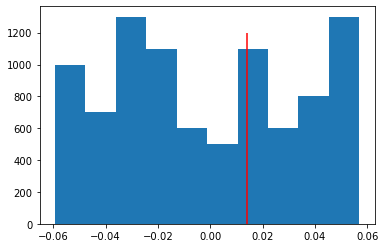

In [100]:
field = "df"

print("{} value in ground truth map is {}".format(field,makevol(m.paramMap[field],m.mask>0)[idx_max[1],idx_max[2]]))
plt.hist(m.paramMap[field])
plt.vlines(x=makevol(m.paramMap[field],m.mask>0)[idx_max[1],idx_max[2]],ymin=0,ymax=1200,color="red")

(array([1., 1., 0., 1., 0., 1., 1., 0., 1., 1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

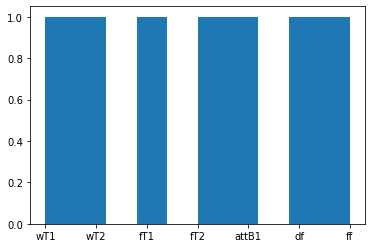

In [82]:
plt.hist(m.paramMap)

In [28]:
m.images_series[idx_max[0],idx_max[1],idx_max[2]]

(-0.017700108566527175+0.0057833566807044354j)

In [30]:
simulations[idx_max[0],idx_max[1],idx_max[2]]

(0.026679995408650112-0.007544962842699548j)

In [31]:
error_all[idx_max[0],idx_max[1],idx_max[2]]

0.04633829658247591

In [32]:
np.abs(m.images_series[idx_max[0],idx_max[1],idx_max[2]]-simulations[idx_max[0],idx_max[1],idx_max[2]])

0.046338296582475916

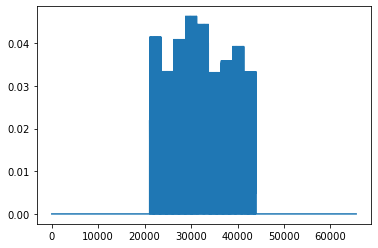

In [24]:
plt.plot(np.max(error_all.reshape(1400,-1),axis=0))

In [ ]:
plt.plot(np.max(error_all.reshape(1400,-1),axis=0))

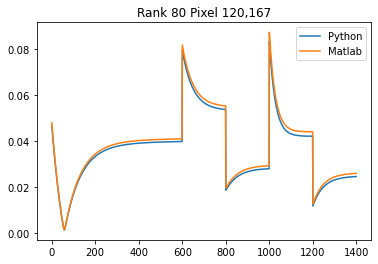

In [17]:
rank=80
error_all = np.abs(m.images_series-simulations)
idx_max = np.argsort((error_all.flatten()))[-rank]
idx_max=np.unravel_index(idx_max,error_all.shape)
plt.plot(np.abs(m.images_series[:,idx_max[1],idx_max[2]]),label="Python")
plt.plot(np.abs(simulations[:,idx_max[1],idx_max[2]]),label="Matlab")
plt.title("Rank {} Pixel {},{}".format(rank,idx_max[1],idx_max[2]))

plt.legend()

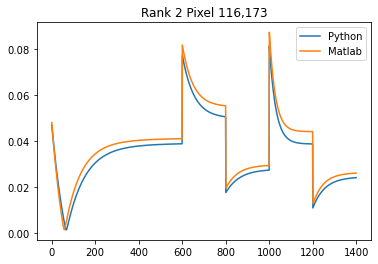

In [145]:
rank=2
error_all = np.abs(m.images_series-simulations)
idx_max = np.argsort((error_all.flatten()))[-rank]
idx_max=np.unravel_index(idx_max,error_all.shape)
plt.plot(np.abs(m.images_series[:,idx_max[1],idx_max[2]]),label="Python")
plt.plot(np.abs(simulations[:,idx_max[1],idx_max[2]]),label="Matlab")
plt.title("Rank {} Pixel {},{}".format(rank,idx_max[1],idx_max[2]))

plt.legend()

In [146]:
field = "ff"

print("{} value in ground truth map is {}".format(field,makevol(m.paramMap[field],m.mask>0)[idx_max[1],idx_max[2]]))
print("{} value in python map is {}".format(field,makevol(all_maps_adj[2][0][field],all_maps_adj[2][1]>0)[idx_max[1],idx_max[2]]))
print("{} value in matlab map is {}".format(field,makevol(map_rebuilt_Matlab.paramMap[field],map_rebuilt_Matlab.mask>0)[idx_max[1],idx_max[2]]))

ff value in ground truth map is 0.95
ff value in python map is 0.946693651239975
ff value in matlab map is 0.95


/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [147]:
field = "wT1"

print("{} value in ground truth map is {}".format(field,makevol(m.paramMap[field],m.mask>0)[idx_max[1],idx_max[2]]))
print("{} value in python map is {}".format(field,makevol(all_maps_adj[2][0][field],all_maps_adj[2][1]>0)[idx_max[1],idx_max[2]]))
print("{} value in matlab map is {}".format(field,makevol(map_rebuilt_Matlab.paramMap[field],map_rebuilt_Matlab.mask>0)[idx_max[1],idx_max[2]]))

wT1 value in ground truth map is 1834.0
wT1 value in python map is 1999.0
wT1 value in matlab map is 1650.0


In [136]:
makevol(all_maps_adj[2][0]["wT1"],all_maps_adj[2][1]>0)[idx_max[1],idx_max[2]]

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1999.0

In [137]:
makevol(map_rebuilt_Matlab.paramMap["wT1"],map_rebuilt_Matlab.mask>0)[idx_max[1],idx_max[2]]

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1750.0

In [127]:
idx_max

(800, 112, 167)

In [118]:
error_all_reshaped = error_all.reshape(1400,-1)
idx_sorted_on_path=np.argsort(error_all_reshaped,axis=0)

In [125]:
np.argsort(error_all_reshaped.flatten())

array([       0, 58913470, 58913469, ..., 52458409, 52458669, 52459951])

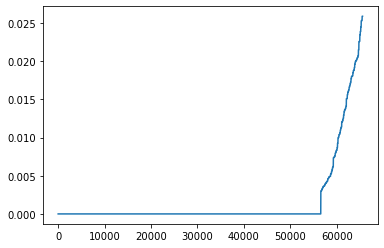

In [120]:
idx_sorted_along_sig = np.argmax(error_all_reshaped[idx_sorted_on_path[-2,:],range(error_all_reshaped.shape[1])])

In [116]:
idx_sorted_on_path[-2,:].shape

(65536,)

In [117]:
error_all.shape

(1400, 256, 256)